In [47]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import dateutil
import numpy as np
import json
import os

In [49]:
# Necessary headers for all requests
headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json'
}

base_url = 'https://api.c3.ai/covid/api/1'

In [50]:
# List outbreaklocations
data = json.dumps({
    'spec': {
        'filter': 'contains(id, "Illinois")',
        'include': 'id, name, fips, lineList',
        'limit': -1,
        'offset': 0,
    }
})

r = requests.post(os.path.join(base_url, 'outbreaklocation', 'fetch'),
                  headers=headers,
                  data=data)

outbreak_location_fetch_df = pd.DataFrame(json.loads(r.text)['objs'])

In [51]:
# Show all 'Illinois' outbreak locations
outbreak_location_fetch_df[outbreak_location_fetch_df.lineList.notna()]

,fips,id,name,meta,version,typeIdent,lineList
9,{'id': '17019'},Champaign_Illinois_UnitedStates,Champaign,"{'fetchInclude': '[id,name,fips,{lineList:[id]...",9175054,EP_LOC,[{'location': {'id': 'Champaign_Illinois_Unite...
10,NaN,Chicago_Illinois_UnitedStates,Chicago,"{'fetchInclude': '[id,name,fips,{lineList:[id]...",2359297,EP_LOC,[{'location': {'id': 'Chicago_Illinois_UnitedS...
14,{'id': '17027'},Clinton_Illinois_UnitedStates,Clinton,"{'fetchInclude': '[id,name,fips,{lineList:[id]...",9306126,EP_LOC,[{'location': {'id': 'Clinton_Illinois_UnitedS...
16,{'id': '17031'},Cook_Illinois_UnitedStates,Cook,"{'fetchInclude': '[id,name,fips,{lineList:[id]...",9699342,EP_LOC,[{'location': {'id': 'Cook_Illinois_UnitedStat...
18,{'id': '17035'},Cumberland_Illinois_UnitedStates,Cumberland,"{'fetchInclude': '[id,name,fips,{lineList:[id]...",8781838,EP_LOC,[{'location': {'id': 'Cumberland_Illinois_Unit...
19,{'id': '17037'},DeKalb_Illinois_UnitedStates,DeKalb,"{'fetchInclude': '[id,name,fips,{lineList:[id]...",9502734,EP_LOC,[{'location': {'id': 'DeKalb_Illinois_UnitedSt...
21,{'id': '17041'},Douglas_Illinois_UnitedStates,Douglas,"{'fetchInclude': '[id,name,fips,{lineList:[id]...",8585230,EP_LOC,[{'location': {'id': 'Douglas_Illinois_UnitedS...
22,{'id': '17043'},DuPage_Illinois_UnitedStates,DuPage,"{'fetchInclude': '[id,name,fips,{lineList:[id]...",9699342,EP_LOC,[{'location': {'id': 'DuPage_Illinois_UnitedSt...
28,{'id': '17055'},Franklin_Illinois_UnitedStates,Franklin,"{'fetchInclude': '[id,name,fips,{lineList:[id]...",9437198,EP_LOC,[{'location': {'id': 'Franklin_Illinois_United...
32,{'id': '17063'},Grundy_Illinois_UnitedStates,Grundy,"{'fetchInclude': '[id,name,fips,{lineList:[id]...",9568270,EP_LOC,[{'location': {'id': 'Grundy_Illinois_UnitedSt...


In [52]:
# Ingest metrics
def ingest_evalmetrics(json_result):
    results = []
    for ID in json_result['result']:
        for expression in json_result['result'][ID]:
            if json_result['result'][ID][expression]['type'] == 'MaterializedTimeseriesDouble':
                count = json_result['result'][ID][expression]['count']
                dates = pd.Series(json_result['result'][ID][expression]['dates'])
                dates = dates.apply(lambda d: dateutil.parser.isoparse(d))
                data = pd.Series(json_result['result'][ID][expression]['data']).astype(np.int)
                missing = pd.Series(json_result['result'][ID][expression]['missing']).astype(np.int)
                
                results.append(pd.DataFrame({'date': dates,
                                             'data': data,
                                             'id': [ID]*count,
                                             'expression': [expression]*count,
                                             'missing': missing}))
    return pd.concat(results)

In [130]:
data = json.dumps({
  "spec": {
    "ids": [
      "Champaign_Illinois_UnitedStates",
      "DuPage_Illinois_UnitedStates",
      "Cook_Illinois_UnitedStates"
    ],
    "expressions": [
      "JHU_ConfirmedCases",
      "JHU_ConfirmedDeaths",
      "JHU_ConfirmedRecoveries",
    ],
    "interval": "DAY",
    "start": "2020-01-01",
    "end": "2020-06-11"
  }
})

r = requests.post(os.path.join(base_url, 'outbreaklocation', 'evalmetrics'),
                  headers=headers,
                  data=data)
cases_df = ingest_evalmetrics(json.loads(r.text))

Text(0.5, 0, 'Date')

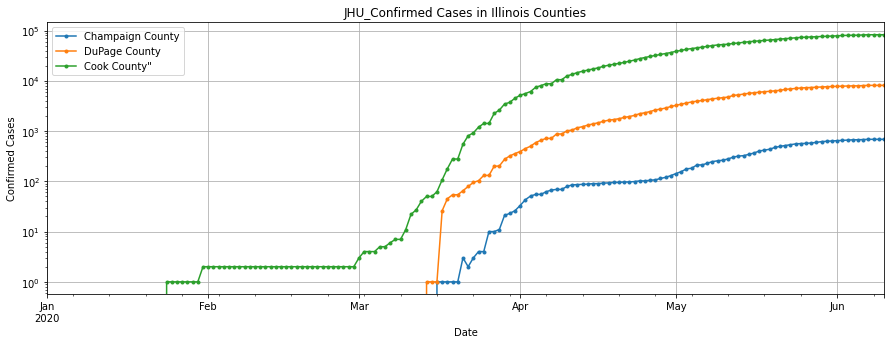

In [131]:
_, ax = plt.subplots(1, figsize=(15,5))

cases_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Champaign County')
cases_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='DuPage County')
cases_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Cook County"')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed Cases in Illinois Counties")
ax.set_ylabel("Confirmed Cases")
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

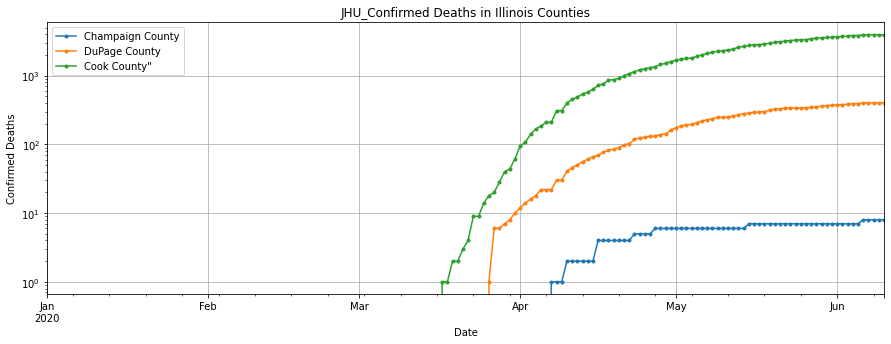

In [132]:
_, ax = plt.subplots(1, figsize=(15,5))

cases_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Champaign County')
cases_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='DuPage County')
cases_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Cook County"')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed Deaths in Illinois Counties")
ax.set_ylabel("Confirmed Deaths")
ax.set_xlabel('Date')

In [133]:
# Get populations
data = json.dumps({
    'spec': {
        'filter': 'contains(id, "_Illinois_")',
    }
})

r = requests.post(os.path.join(base_url, 'outbreaklocation', 'fetch'),
                  headers=headers,
                  data=data)
illinois_location_df = pd.DataFrame(json.loads(r.text)['objs']).set_index('id')

In [134]:
illinois_location_df

,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,populationOfAllChildren,locationType,populationCDS,location,fips,name,meta,version,typeIdent
id,,,,,,,,,,,,,
Adams_Illinois_UnitedStates,25.0,248.0,307.0,65435.0,65435.0,county,65435.0,{'value': {'id': 'Adams_Illinois_UnitedStates'...,{'id': '17001'},Adams,"{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",9699344,EP_LOC
Alexander_Illinois_UnitedStates,NaN,NaN,NaN,5761.0,5761.0,county,5761.0,{'value': {'id': 'Alexander_Illinois_UnitedSta...,{'id': '17003'},"Alexander County, Illinois, United States","{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",8257551,EP_LOC
Bond_Illinois_UnitedStates,6.0,32.0,42.0,16426.0,16426.0,county,16426.0,{'value': {'id': 'Bond_Illinois_UnitedStates'}...,{'id': '17005'},Bond,"{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",9502736,EP_LOC
Boone_Illinois_UnitedStates,NaN,NaN,NaN,53544.0,53544.0,county,53544.0,{'value': {'id': 'Boone_Illinois_UnitedStates'...,{'id': '17007'},Boone,"{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",8650768,EP_LOC
Brown_Illinois_UnitedStates,NaN,NaN,NaN,6578.0,6578.0,county,6578.0,{'value': {'id': 'Brown_Illinois_UnitedStates'...,{'id': '17009'},"Brown County, Illinois, United States","{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",7208969,EP_LOC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Whiteside_Illinois_UnitedStates,13.0,121.0,123.0,55175.0,55175.0,county,55175.0,{'value': {'id': 'Whiteside_Illinois_UnitedSta...,{'id': '17195'},Whiteside,"{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",10354720,EP_LOC
Will_Illinois_UnitedStates,97.0,850.0,1023.0,690743.0,690743.0,county,690743.0,{'value': {'id': 'Will_Illinois_UnitedStates'}...,{'id': '17197'},Will,"{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",10223647,EP_LOC
Williamson_Illinois_UnitedStates,28.0,294.0,327.0,66597.0,66597.0,county,66597.0,{'value': {'id': 'Williamson_Illinois_UnitedSt...,{'id': '17199'},Williamson,"{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",10158113,EP_LOC


In [135]:
cases_per_capita_df = cases_df.join(illinois_location_df[['latestTotalPopulation']], on='id')
cases_per_capita_df.data = cases_per_capita_df.data.astype(np.float32)/cases_per_capita_df.latestTotalPopulation

Text(0.5, 0, 'Date')

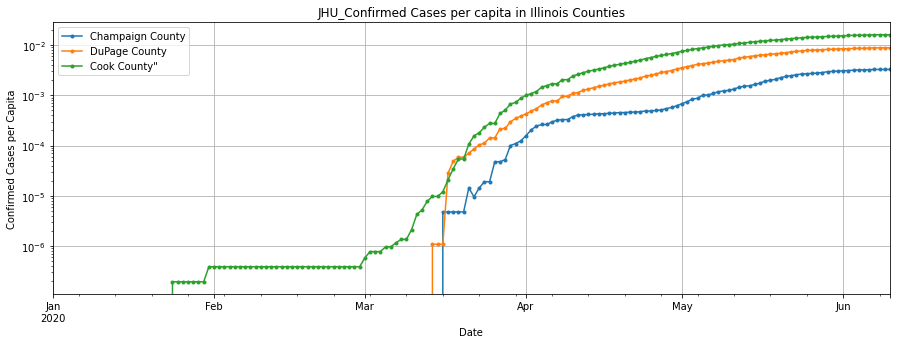

In [136]:
_, ax = plt.subplots(1, figsize=(15,5))

cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Champaign County')
cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='DuPage County')
cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Cook County"')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed Cases per capita in Illinois Counties")
ax.set_ylabel("Confirmed Cases per Capita")
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

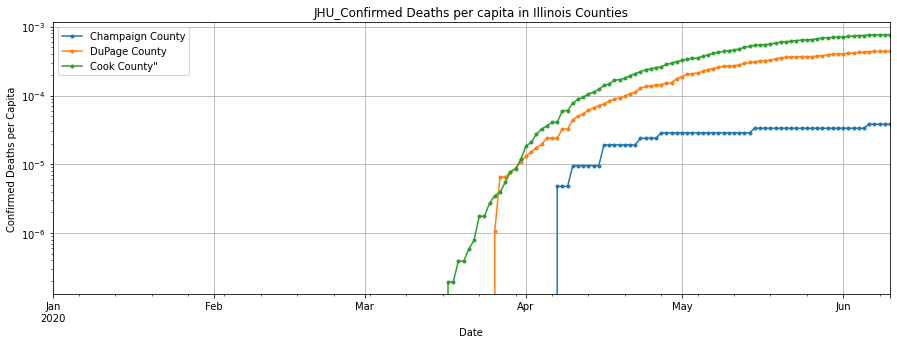

In [137]:
_, ax = plt.subplots(1, figsize=(15,5))

cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Champaign County')
cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='DuPage County')
cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Cook County"')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed Deaths per capita in Illinois Counties")
ax.set_ylabel("Confirmed Deaths per Capita")
ax.set_xlabel('Date')

In [194]:
def build_case_differences(cases_df):
    data = cases_df['data']
    cases_df['data_diff'] = data-data.shift(1)
    cases_df = cases_df.dropna()
    return cases_df

Text(0.5, 0, 'Date')

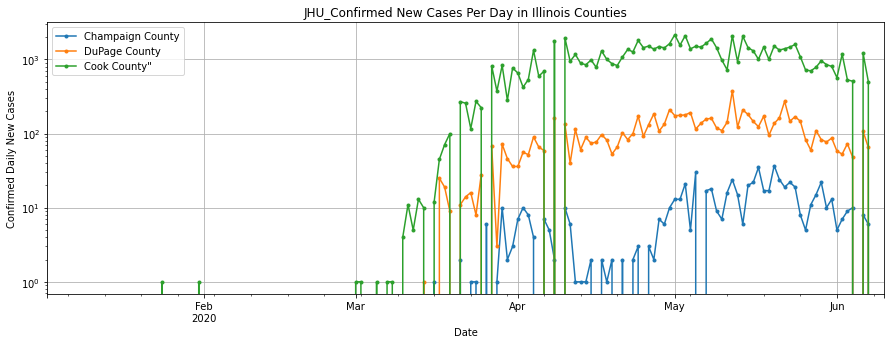

In [198]:
_, ax = plt.subplots(1, figsize=(15,5))

build_case_differences(cases_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates']).plot(y='data_diff', ax=ax, marker='.', label='Champaign County')
build_case_differences(cases_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates']).plot(y='data_diff', ax=ax, marker='.', label='DuPage County')
build_case_differences(cases_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates']).plot(y='data_diff', ax=ax, marker='.', label='Cook County"')

ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed New Cases Per Day in Illinois Counties")
ax.set_ylabel("Confirmed Daily New Cases")
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

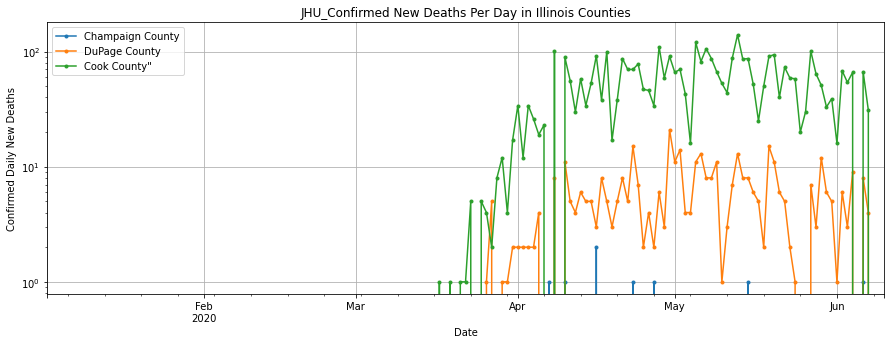

In [199]:
_, ax = plt.subplots(1, figsize=(15,5))

build_case_differences(cases_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates']).plot(y='data_diff', ax=ax, marker='.', label='Champaign County')
build_case_differences(cases_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates']).plot(y='data_diff', ax=ax, marker='.', label='DuPage County')
build_case_differences(cases_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates']).plot(y='data_diff', ax=ax, marker='.', label='Cook County"')

ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed New Deaths Per Day in Illinois Counties")
ax.set_ylabel("Confirmed Daily New Deaths")
ax.set_xlabel('Date')

In [207]:
def build_case_differences_per_capita(cases_per_capita_df):
    data = cases_per_capita_df['data']
    cases_per_capita_df['data_diff'] = data-data.shift(1)
    cases_per_capita_df = cases_per_capita_df.dropna()
    cases_per_capita_df['data_diff_per_capita'] = cases_per_capita_df['data_diff']/cases_per_capita_df['latestTotalPopulation']
    return cases_per_capita_df

<ipython-input-207-e75132945bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_per_capita_df['data_diff_per_capita'] = cases_per_capita_df['data_diff']/cases_per_capita_df['latestTotalPopulation']
<ipython-input-207-e75132945bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_per_capita_df['data_diff_per_capita'] = cases_per_capita_df['data_diff']/cases_per_capita_df['latestTotalPopulation']
<ipython-input-207-e75132945bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy o

Text(0.5, 0, 'Date')

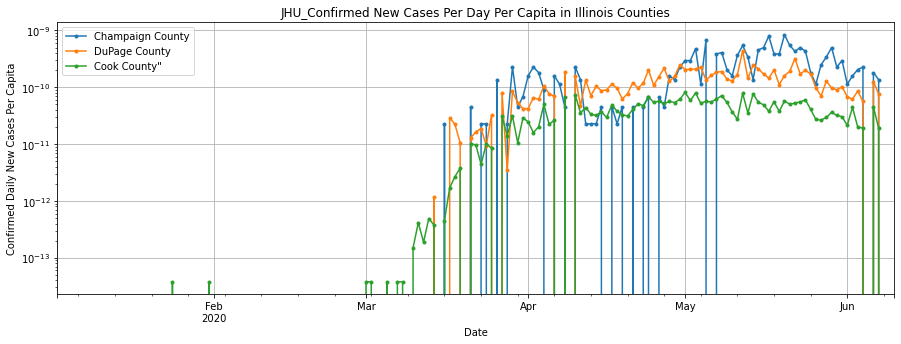

In [209]:
_, ax = plt.subplots(1, figsize=(15,5))

build_case_differences_per_capita(cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates']).plot(y='data_diff_per_capita', ax=ax, marker='.', label='Champaign County')
build_case_differences_per_capita(cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates']).plot(y='data_diff_per_capita', ax=ax, marker='.', label='DuPage County')
build_case_differences_per_capita(cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates']).plot(y='data_diff_per_capita', ax=ax, marker='.', label='Cook County"')

ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed New Cases Per Day Per Capita in Illinois Counties")
ax.set_ylabel("Confirmed Daily New Cases Per Capita")
ax.set_xlabel('Date')

<ipython-input-207-e75132945bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_per_capita_df['data_diff_per_capita'] = cases_per_capita_df['data_diff']/cases_per_capita_df['latestTotalPopulation']
<ipython-input-207-e75132945bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_per_capita_df['data_diff_per_capita'] = cases_per_capita_df['data_diff']/cases_per_capita_df['latestTotalPopulation']
<ipython-input-207-e75132945bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy o

Text(0.5, 0, 'Date')

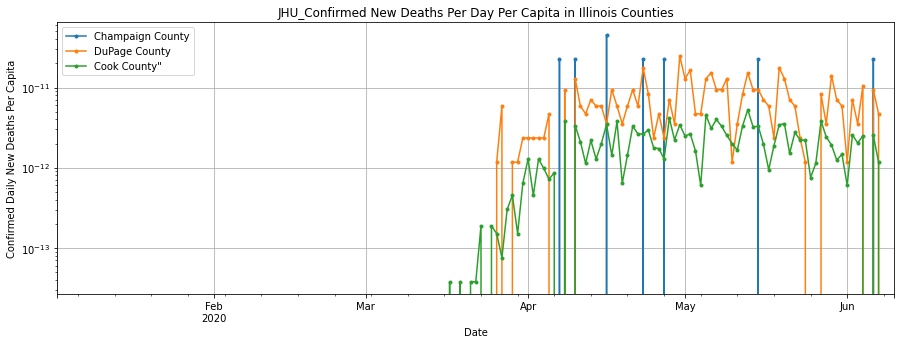

In [210]:
_, ax = plt.subplots(1, figsize=(15,5))

build_case_differences_per_capita(cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates']).plot(y='data_diff_per_capita', ax=ax, marker='.', label='Champaign County')
build_case_differences_per_capita(cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates']).plot(y='data_diff_per_capita', ax=ax, marker='.', label='DuPage County')
build_case_differences_per_capita(cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates']).plot(y='data_diff_per_capita', ax=ax, marker='.', label='Cook County"')

ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed New Deaths Per Day Per Capita in Illinois Counties")
ax.set_ylabel("Confirmed Daily New Deaths Per Capita")
ax.set_xlabel('Date')